# Loading Files

In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import distance
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Process NetCDF files

In [4]:
# Arrays containing data for each file
unwrappedPhase = []
coherence = []
mask = []
latitude = []
longitude = []
imageExtent = []
cmDisplacement = []

# Wavelength of satellite signal
wavelength = 0

In [5]:
# Find all NetCDF files for an event and add their data to the corresponding array
# we will later index into the above arrays to access a specific file's data

data_path = "/content/drive/My Drive/NASA hackathon/Code/data/ridgecrest/"
i = 0

for filename in os.listdir(data_path):
    if filename.endswith("nc") and filename != "filteredFile.nc":  
        print(filename)
        nc = netCDF4.Dataset(data_path + filename)

        nc_data = nc.groups['science'].groups['grids'].groups['data']

        unwrappedPhase.append(nc_data.variables['unwrappedPhase'][:].data)
        coherence.append(nc_data.variables['coherence'][:].data)
        mask.append(nc_data.variables['unwrappedPhase'][:].mask)
        latitude.append(nc_data.variables['latitude'][:].data)
        longitude.append(nc_data.variables['longitude'][:].data)
        imageExtent.append([np.min(longitude[i]),np.max(longitude[i]),np.min(latitude[i]),np.max(latitude[i])])

        if i == 0: # executed once
            wavelength = float(nc.groups['science'].groups['radarMetaData'].variables['wavelength'][:].data) * 100

        i += 1
        nc.close()


S1-GUNW-D-R-071-tops-20190728_20180627-135213-36450N_34472N-PP-a1ea-v2_0_2.nc
S1-GUNW-D-R-071-tops-20190728_20190622-135213-36450N_34472N-PP-b4b2-v2_0_2.nc
S1-GUNW-D-R-071-tops-20190728_20190704-135213-36450N_34472N-PP-9181-v2_0_2.nc
S1-GUNW-D-R-071-tops-20190728_20180826-135212-00119W_00034N-PP-2d1f-v2_0_5.nc
S1-GUNW-D-R-071-tops-20190716_20180627-135212-36450N_34472N-PP-b69d-v2_0_2.nc
S1-GUNW-D-R-071-tops-20190716_20190610-135212-36450N_34472N-PP-f29b-v2_0_2.nc
S1-GUNW-D-R-071-tops-20190716_20190622-135212-36450N_34472N-PP-7915-v2_0_2.nc
S1-GUNW-D-R-071-tops-20190716_20190704-135212-36450N_34472N-PP-bf9f-v2_0_2.nc
S1-GUNW-D-R-071-tops-20190716_20180814-135212-00119W_00034N-PP-3114-v2_0_5.nc


## Replace 0s with NaNs

In [6]:
for i in range(len(unwrappedPhase)):

    inds_to_keep = ~mask[i]
    mat_shape = inds_to_keep.shape

    noZeroesMeasurement = np.zeros(mat_shape) + np.nan
    noZeroesMeasurement[inds_to_keep] = unwrappedPhase[i][inds_to_keep]
    unwrappedPhase[i] = noZeroesMeasurement

    cmDisplacement.append(wavelength * unwrappedPhase[i] / (2 * np.pi))

## Display graphs of original files

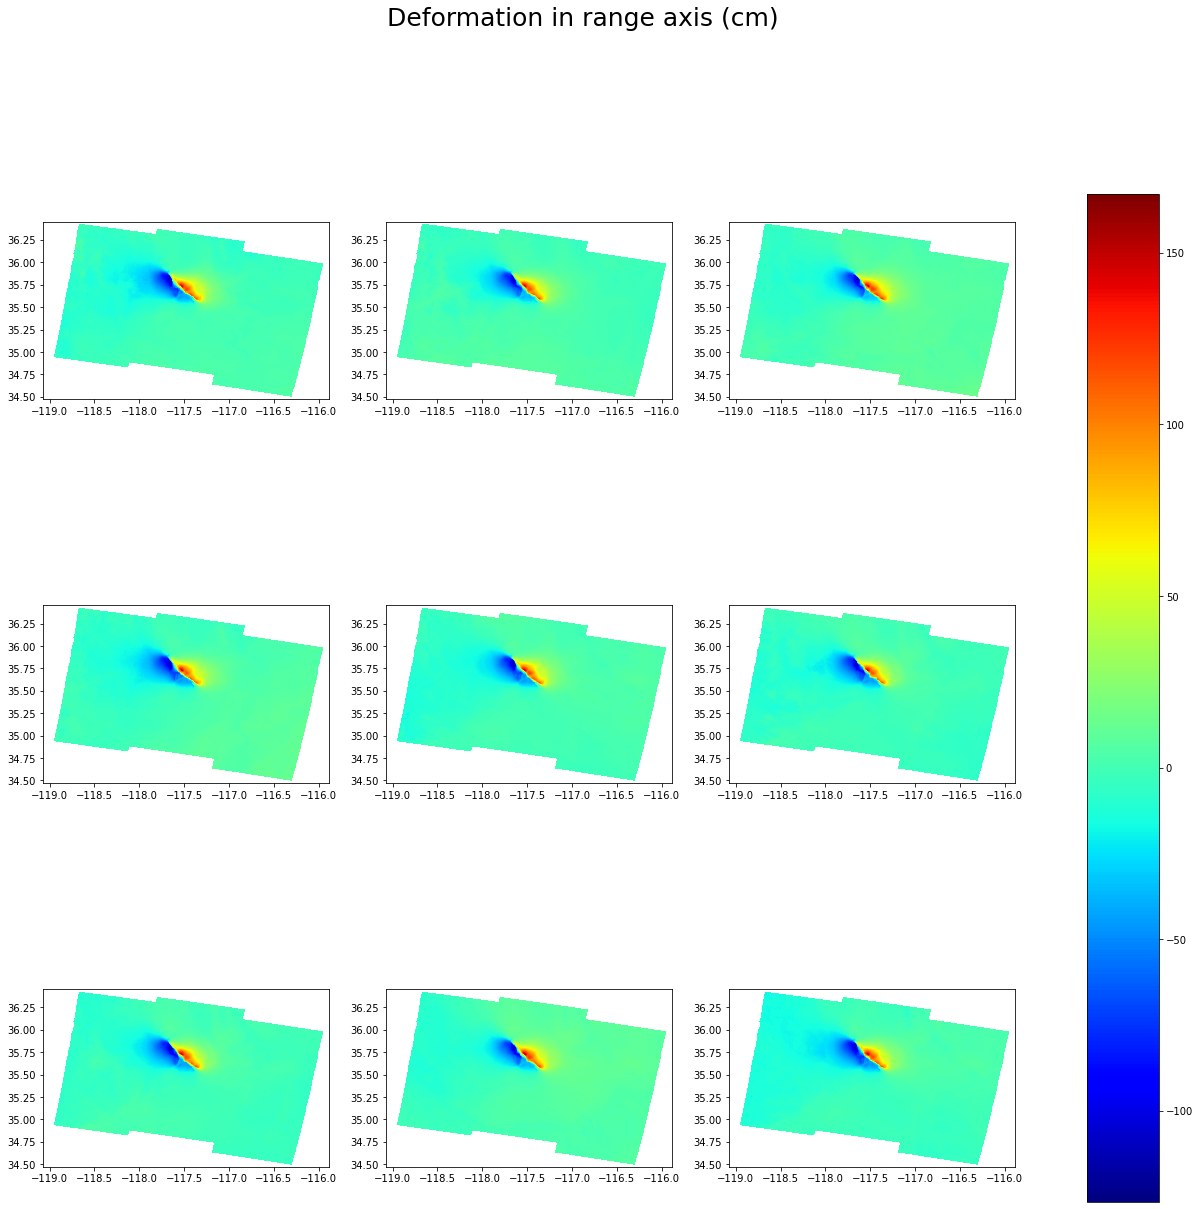

In [7]:
figure, ax1 = plt.subplots(3, 3, figsize = (20, 20))
ax = []
ax.append(plt.subplot(3, 3, 1))

for i in range(len(unwrappedPhase)):
    ax.append(plt.subplot(3, 3, i + 1, sharex=ax[0], sharey=ax[0]))
    im = plt.imshow(cmDisplacement[i], extent = imageExtent[i])
    plt.set_cmap('jet')

figure.suptitle('Deformation in range axis (cm)', fontsize=25)

figure.subplots_adjust(right=0.8)
cbar_ax = figure.add_axes([0.85, 0.15, 0.05, 0.7])
figure.colorbar(im, cax=cbar_ax)

plt.show()


# Filtering

## Filtering Functions

In [8]:
# filtered arrays
filteredLatitude = latitude[0]
filteredLongitude = longitude[0]
filteredUnwrappedPhase = unwrappedPhase[0]
filteredCoherence = coherence[0]

CELL_DIMENSION = 9 # odd so that you can construct a nice square cell centered on a position

def unfilteredSubmatrix(measurement, posX, posY):

    """
    Compute the square cell centered at the position posX posY in some file's data.

    Parameters: 
    ---------------
    measurement: index of measurement in the original arrays
    posX: index in longitude array
    posY: index in latitude array

    Returns:
    --------------
    Cell centered at selected point in file's data.

    """

    currentRow = []
    submatrix = []

    for i in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
        for j in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
            currentRow.append(unwrappedPhase[measurement][posY + j][posX + i])
        submatrix.append(currentRow)
        currentRow = []
    
    return submatrix


def filteredSubmatrix(posX, posY):

    """
    Compute the square cell centered at the position posX posY in the filtered data.

    Parameters: 
    ---------------
    posX: index in longitude array
    posY: index in latitude array

    Returns:
    --------------
    Cell centered at selected point in the filtered data.

    """

    currentRow = []
    submatrix = []

    for i in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
        for j in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
            currentRow.append(filteredUnwrappedPhase[posY + j][posX + i])
        submatrix.append(currentRow)
        currentRow = []
    
    return submatrix


def flattenMatrix(matrix):

    """
    Flattens a cell into a 1D matrix so that the cosine similarity can be computed.

    Parameters: 
    ---------------
    matrix: matrix to flatten

    Returns:
    --------------
    Flattened matrix

    """

    intermediate = np.array(matrix, dtype=object)
    matrixFlat = np.hstack(intermediate)

    return matrixFlat


def calculateSimilarityFiltered(measurement, posX, posY):

    """
    Compute the cosine similarity between two corresponding cells, in the measurement file and the filtered data.

    Parameters: 
    ---------------
    measurement: index of measurement in the original arrays
    posX: index in longitude array
    posY: index in latitude array

    Returns:
    --------------
    Cosine similarity between two cells

    """

    return 1 - distance.cosine(flattenMatrix(filteredSubmatrix(posX, posY)), 
                               flattenMatrix(unfilteredSubmatrix(measurement, posX, posY)))


def filteredSubCoherence(posX, posY):

    """
    Measures the average coherence value of all indexes in a cell at a certain position in the filtered array.

    Parameters: 
    ---------------
    posX: index in longitude array
    posY: index in latitude array

    Returns:
    --------------
    average coherence value in the specified cell

    """

    sumCoherence = 0;

    for i in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
        for j in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
            sumCoherence += filteredCoherence[posY + j][posX + i]
    
    return sumCoherence / np.square(CELL_DIMENSION)


def unfilteredCoherence(measurement, posX, posY):

    """
    Measures the average coherence value of all indexes in a cell at a 
    certain position from a file.

    Parameters: 
    ---------------
    measurement: index of measurement in the original arrays
    posX: index in longitude array
    posY: index in latitude array

    Returns:
    --------------
    average coherence value in the specified cell

    """

    sumCoherence = 0;

    for i in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
        for j in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
            sumCoherence += coherence[measurement][posY + j][posX + i]
    
    return sumCoherence / np.square(CELL_DIMENSION)


def replaceCleanerSubmatrix(other, posX, posY):

    """
    Chooses the most coherent cell between the current measurement file and the filtered data, edits filtered arrays as necessary.

    Parameters: 
    ---------------
    other: index of measurement in the original arrays
    posX: index in longitude array
    posY: index in latitude array

    """

    if filteredSubCoherence(posX, posY) > unfilteredCoherence(other, posX, posY):
        return;

    else:
        for i in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
            for j in range(-CELL_DIMENSION//2 + 1, CELL_DIMENSION//2 + 1):
                measurementMatrix = unfilteredSubmatrix(other, posX, posY)
                filteredUnwrappedPhase[posY + j][posX + i] = measurementMatrix[i + CELL_DIMENSION//2][j + CELL_DIMENSION//2]


def compareFiltered(other):
    """
    Performs comparison of measurement with filtered array.

    Parameters: 
    ---------------
    other: index of measurement in the original arrays

    """
    similarityThreshold = 0.6
    
    for y in range(CELL_DIMENSION//2 + 1, len(filteredLatitude) - 
                   CELL_DIMENSION - 1, CELL_DIMENSION):
        for x in range(CELL_DIMENSION//2 + 1, len(filteredLongitude) - 
                       CELL_DIMENSION - 1, CELL_DIMENSION):
            similarity = calculateSimilarityFiltered(other, x, y)

            if similarity < similarityThreshold:
                replaceCleanerSubmatrix(other, x, y)



In [9]:
# run comparisons for each file
for i in range(1, len(unwrappedPhase)):
    compareFiltered(i)
    print(f"File comparison #{i} done")

File comparison #1 done
File comparison #2 done
File comparison #3 done
File comparison #4 done
File comparison #5 done
File comparison #6 done
File comparison #7 done
File comparison #8 done


## Filtered Graph!

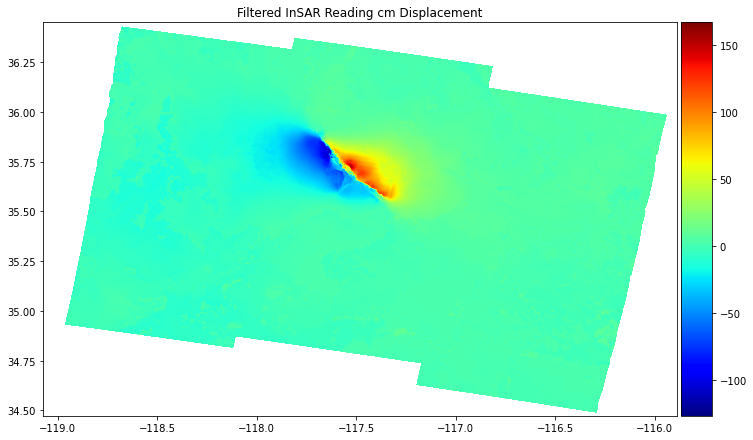

In [16]:
# convert radians to displacement
filteredCmDisplacement = wavelength * filteredUnwrappedPhase / (2 * np.pi)

fig1, ax = plt.subplots(figsize = (12, 12))

plt.imshow(filteredCmDisplacement, extent = imageExtent[0])
plt.set_cmap('jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im, cax=cax)

ax.set_title('Filtered InSAR Reading cm Displacement')

plt.show()